In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import glob
import os
import yaml
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=3, suppress=False)

cuda:0


In [2]:
from postprocessing import report_model

records = []
for path in glob.glob('models/fixed_sigma/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None:
        records.append(record)

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values(by=['objective', 'rel_val_err']).drop(columns='path').set_index(['objective', 'id'])

val_err  rel_val_err  val_loss  train_loss  \
objective        id                                                       
Absolute density 3761106_1  0.010288     0.628100  0.009168    0.000153   
                 3701409_1  0.009525     0.657466  0.009186    0.000157   
                 3761106_0  0.009658     0.673143  0.009191    0.000159   
                 3761096_1  0.009707     0.714740  0.009491    0.000157   
                 3761096_0  0.010555     0.715920  0.010181    0.000142   
                 3701409_0  0.010121     0.725853  0.009625    0.000150   
                 3701261_0  0.010159     0.824749  0.009904    0.000163   
                 3701258_0  0.010684     0.927692  0.010560    0.000156   
                 3701375_0  0.011662     0.960858  0.011812    0.000240   
Fill fraction    3761096_3  0.011922     0.659430  0.632170    0.001423   
                 3701261_2  0.012582     0.705752  0.614066    0.001455   
                 3761096_2  0.016147     0.773104  0.614481    0.001328   
                 3701258_2  0.016832     0.784540  0.646703    0.001319   
                 3701409_2  0.014160     0.811504  0.647295    0.001397   
                 3761106_3  0.013550     0.812552  0.652975    0.001368   
                 3701409_3  0.012996     0.819559  0.590489    0.001454   
                 3701375_1  0.012697     0.831955  0.616078    0.001377   
                 3761106_2  0.010152     0.895238  0.901721    0.001516   
Relative density 3761106_5  0.008319     0.555950  0.059136    0.000312   
                 3701409_5  0.008196     0.569870  0.062450    0.000328   
                 3701261_1  0.009217     0.618454  0.066285    0.000318   
                 3761096_4  0.010330     0.643554  0.069344    0.000349   
                 3701409_4  0.010341     0.704744  0.074218    0.000339   
                 3701258_1  0.010874     0.724628  0.074592    0.000367   
                 3701375_2  0.011504     0.727700  0.076484    0.000369   
                 3761106_4  0.010961     0.845415  0.088287    0.000376   
                 3761096_5  0.013818     0.848212  0.082111    0.000564   

                            val_tmax  num_train_counties  housing  sigma  
objective        id                                                       
Absolute density 3761106_1        10                  31     True      3  
                 3701409_1        10                  31     True      3  
                 3761106_0        10                  31    False      3  
                 3761096_1        10                  31     True      3  
                 3761096_0        10                  31    False      3  
                 3701409_0        10                  31    False      3  
                 3701261_0        10                  31    False      3  
                 3701258_0        10                  31    False      3  
                 3701375_0        10                  31    False      3  
Fill fraction    3761096_3        10                  31     True      3  
                 3701261_2        10                  31    False      3  
                 3761096_2        10                  31    False      3  
                 3701258_2        10                  31    False      3  
                 3701409_2        10                  31    False      3  
                 3761106_3        10                  31     True      3  
                 3701409_3        10                  31     True      3  
                 3701375_1        10                  31    False      3  
                 3761106_2        10                  31    False      3  
Relative density 3761106_5        10                  31     True      3  
                 3701409_5        10                  31     True      3  
                 3701261_1        10                  31    False      3  
                 3761096_4        10                  31    False      3  
                 3701409_4        10                 

## Absolute density model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0103


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000855 |    0.750  |
Spline extrapolation  |   0.00181 |    1.583  |
No dynamics           |   0.00114 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00588 |    0.572  |
Spline extrapolation  |    0.0202 |    1.966  |
No dynamics           |    0.0103 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000965 |    0.495  |
Spline extrapolation  |   0.00429 |    2.202  |
No dynamics           |   0.00195 |    1.000  |
For county = California_Los Angeles
-------------------

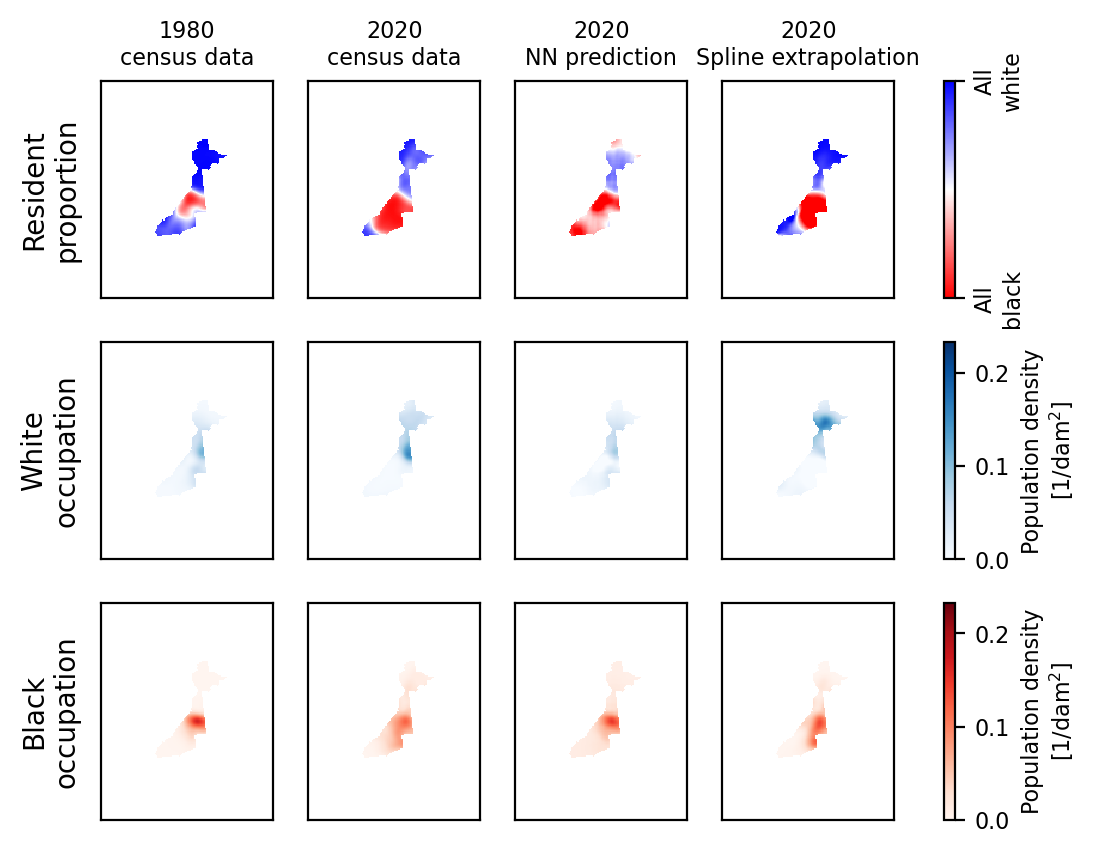

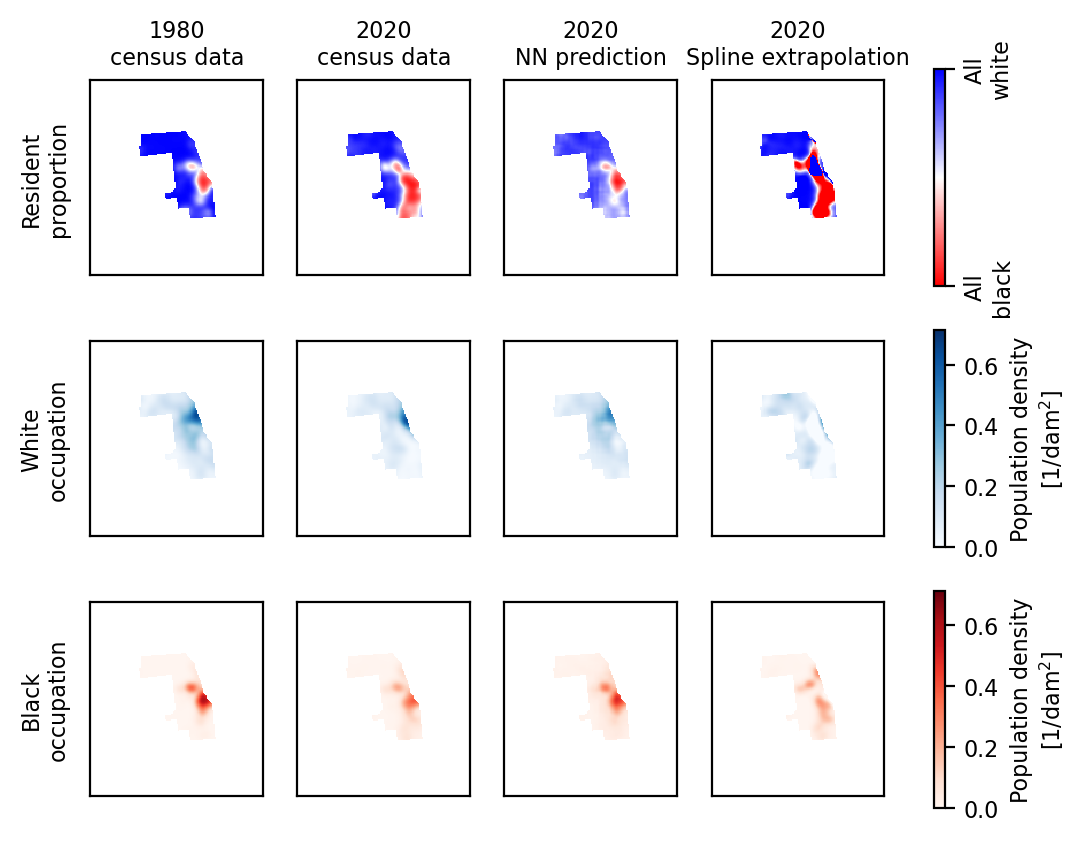

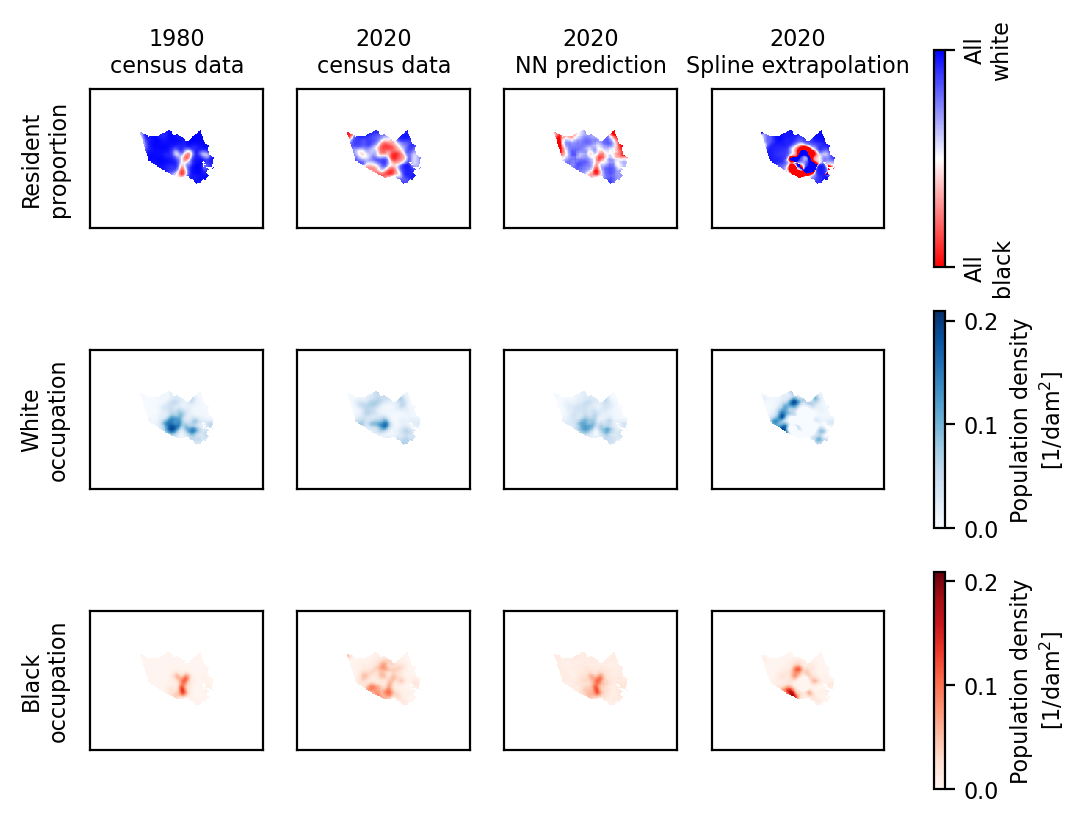

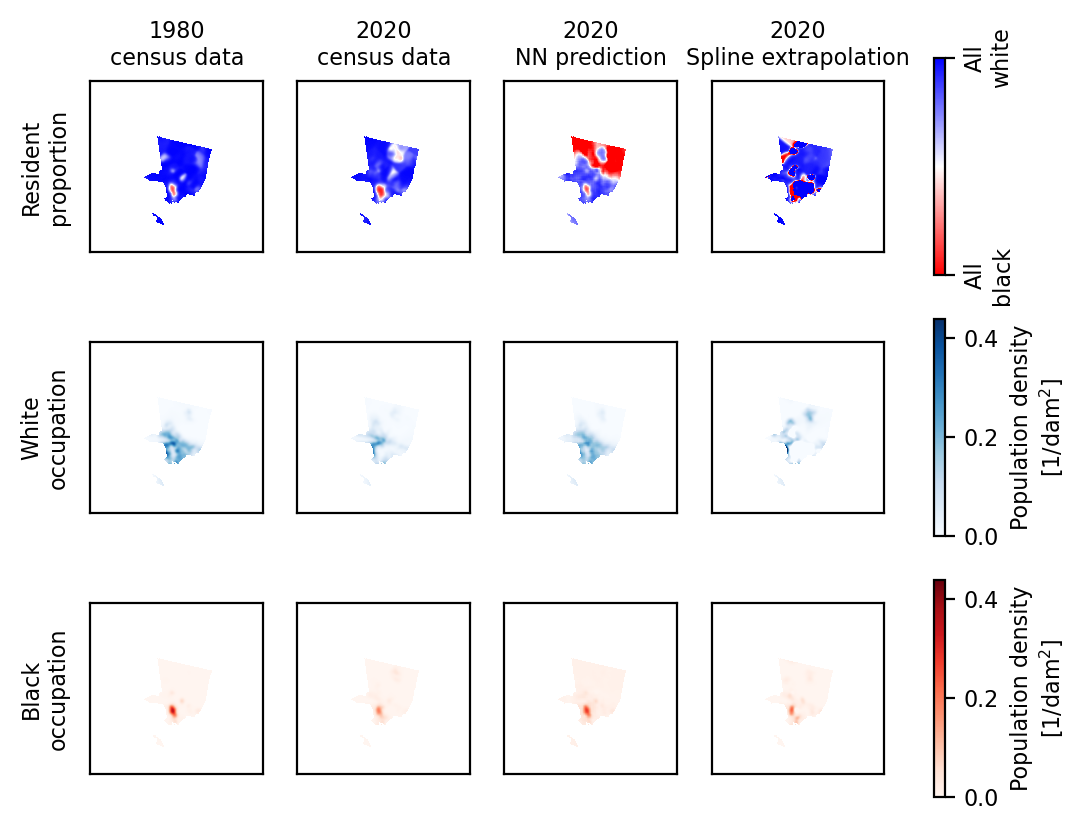

In [3]:
from train_census_nn import get_model
from pprint import pprint
import json
from postprocessing import make_predictions_plot

sub_df = df[df.objective == 'Absolute density'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/fixed_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Deal with rearranged paths
config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.3g}')

## Relative density model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_5/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00832


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000768 |    0.674  |
Spline extrapolation  |   0.00181 |    1.583  |
No dynamics           |   0.00114 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |    0.0045 |    0.437  |
Spline extrapolation  |    0.0202 |    1.966  |
No dynamics           |    0.0103 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00119 |    0.613  |
Spline extrapolation  |   0.00429 |    2.202  |
No dynamics           |   0.00195 |    1.000  |
For county = California_Los Angeles
-------------------

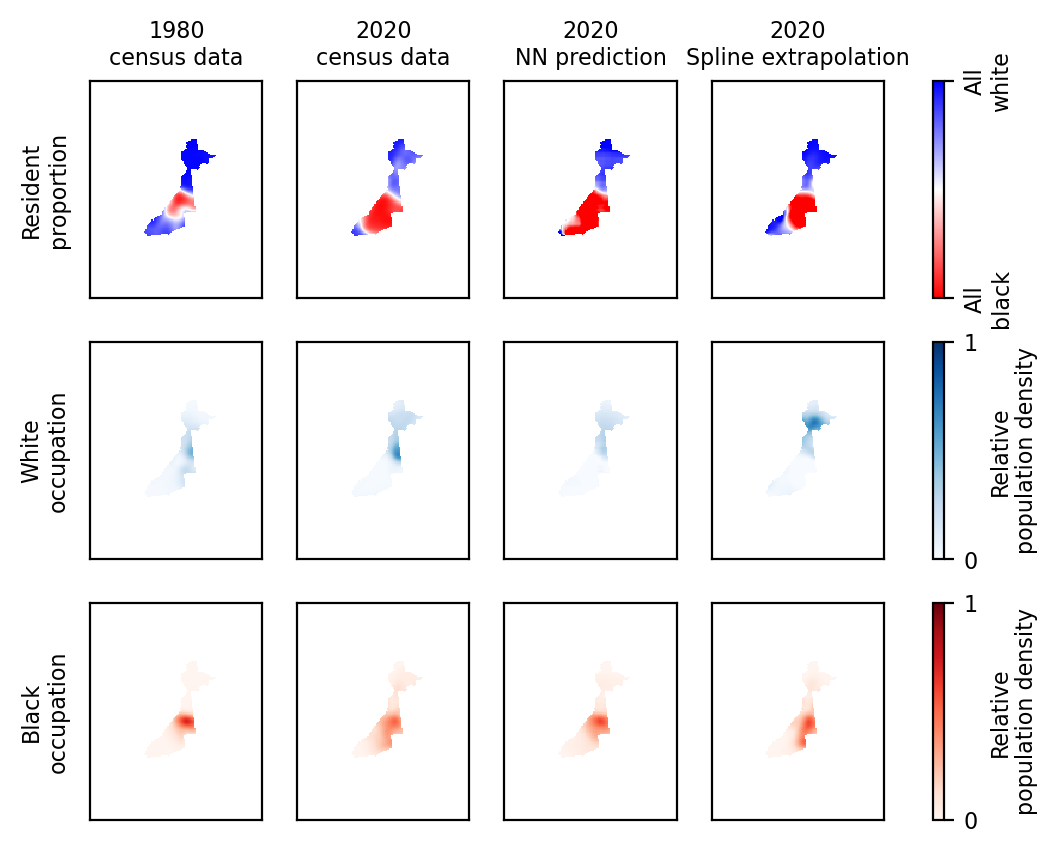

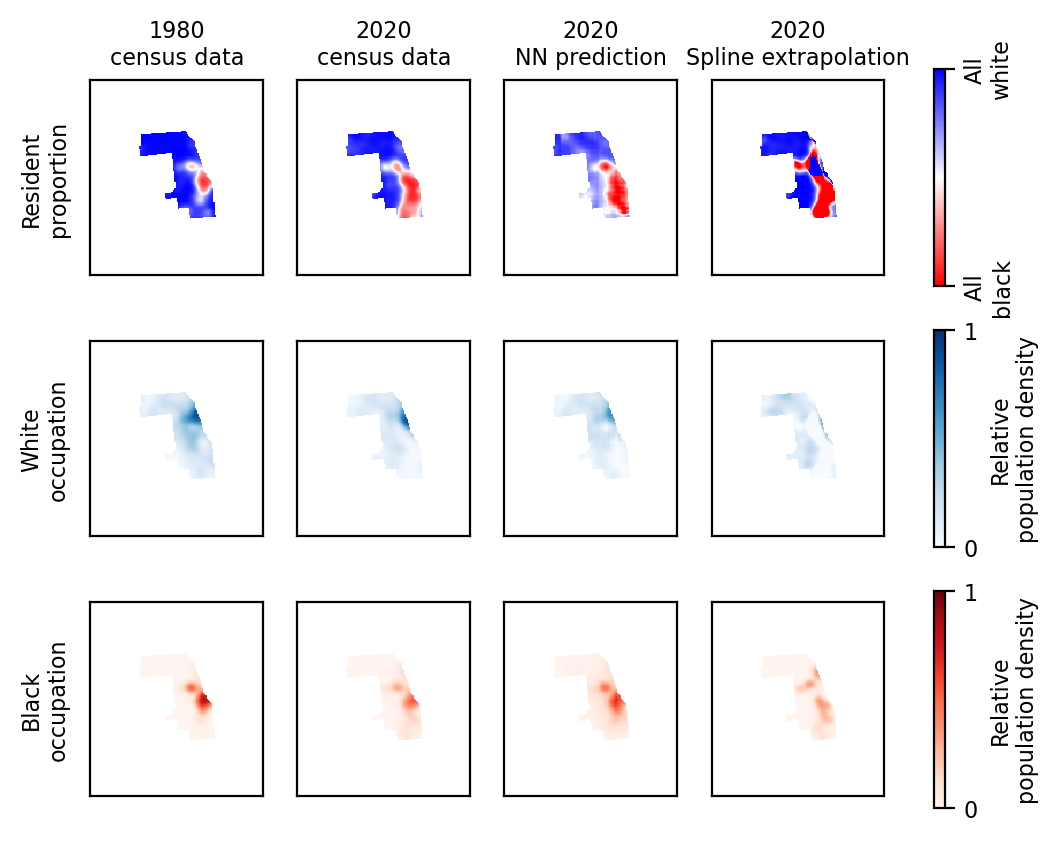

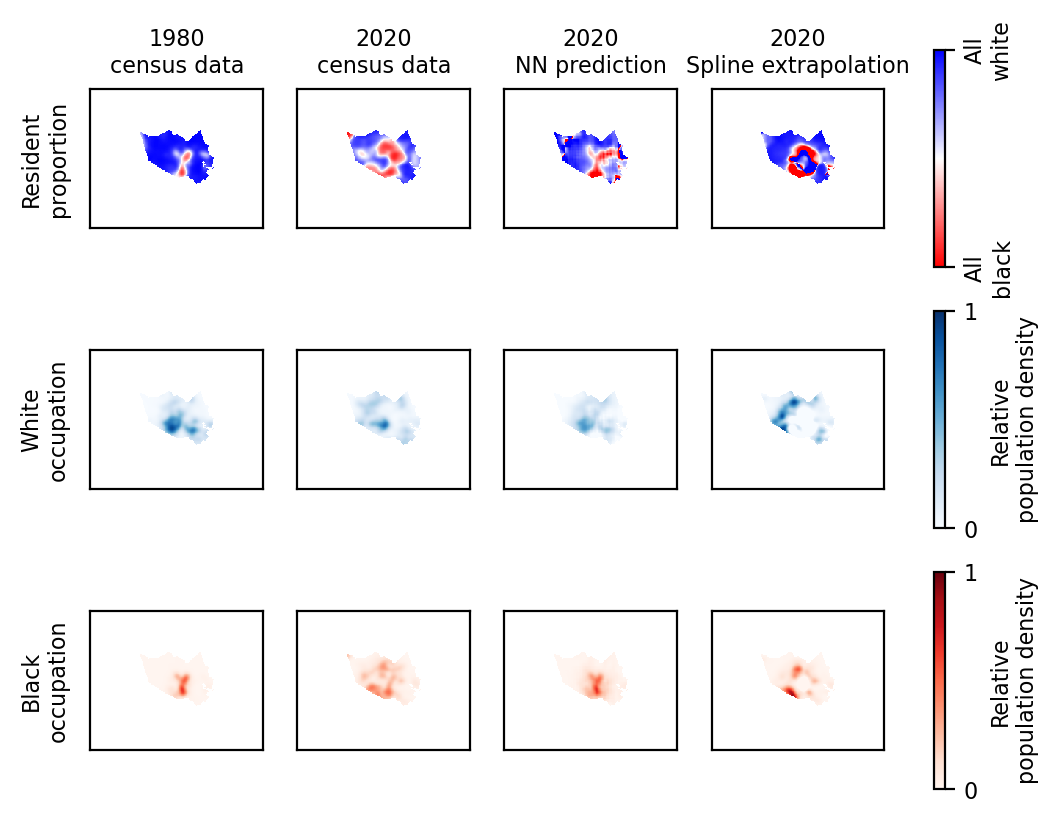

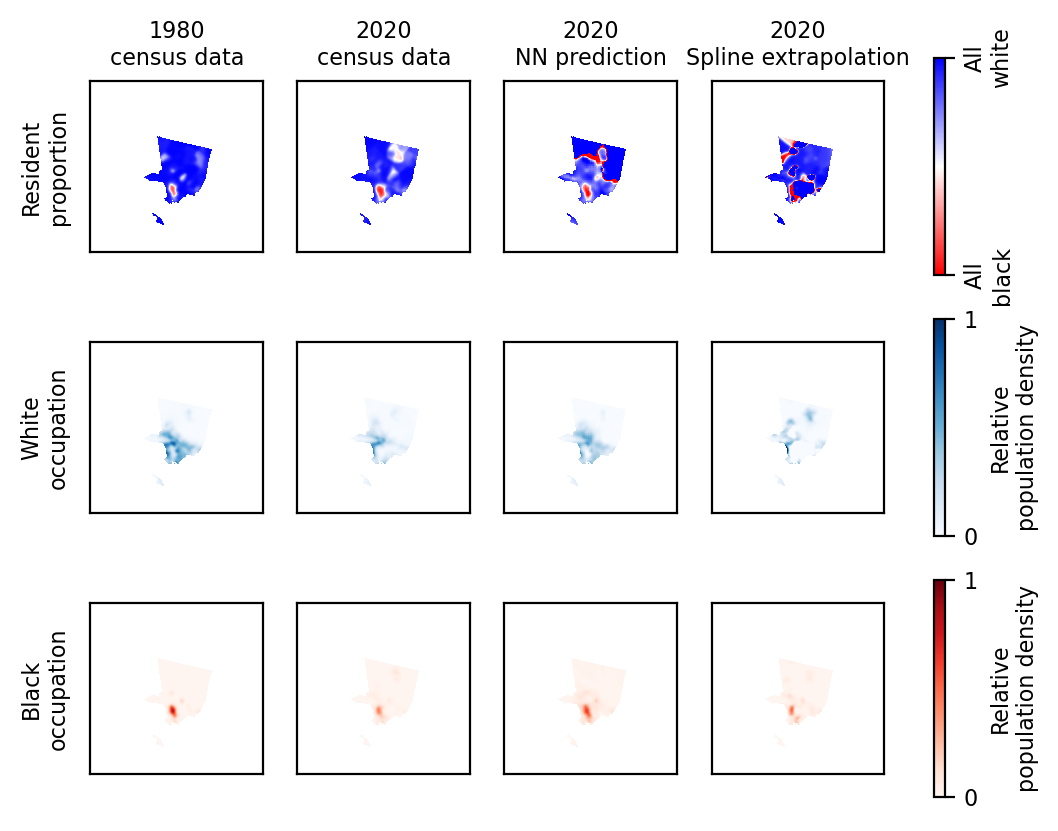

In [4]:
from train_census_nn import *
from pprint import pprint
import json

sub_df = df[df.objective == 'Relative density'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/fixed_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# Deal with rearranged paths
config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.5g}')

## Fill fraction model

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0119


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000829 |    0.727  |
Spline extrapolation  |   0.00181 |    1.583  |
No dynamics           |   0.00114 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00777 |    0.755  |
Spline extrapolation  |    0.0202 |    1.966  |
No dynamics           |    0.0103 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00107 |    0.549  |
Spline extrapolation  |   0.00429 |    2.202  |
No dynamics           |   0.00195 |    1.000  |
For county = California_Los Angeles
-------------------

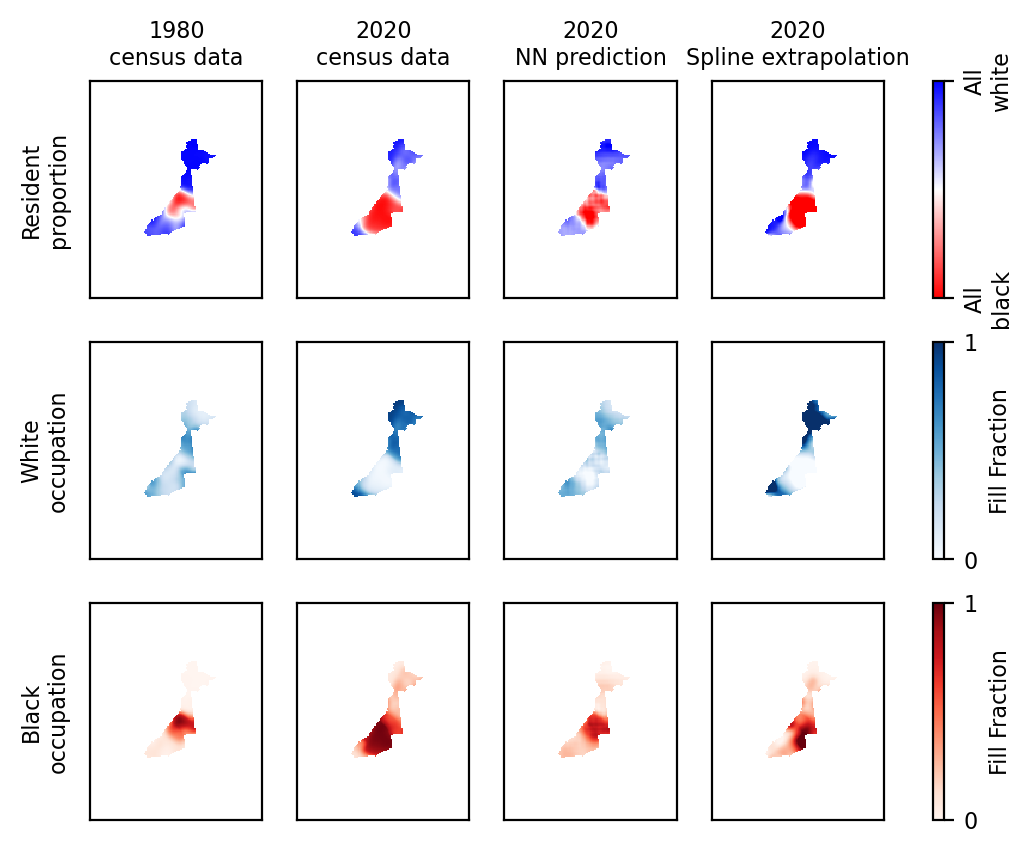

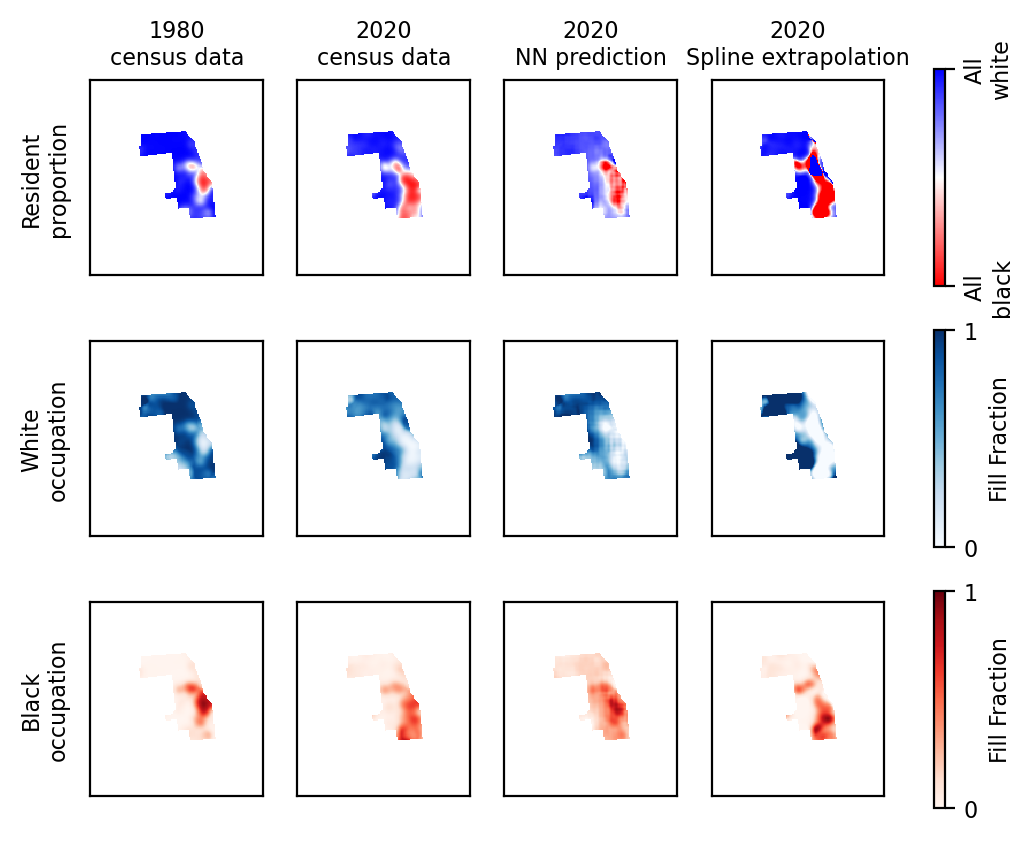

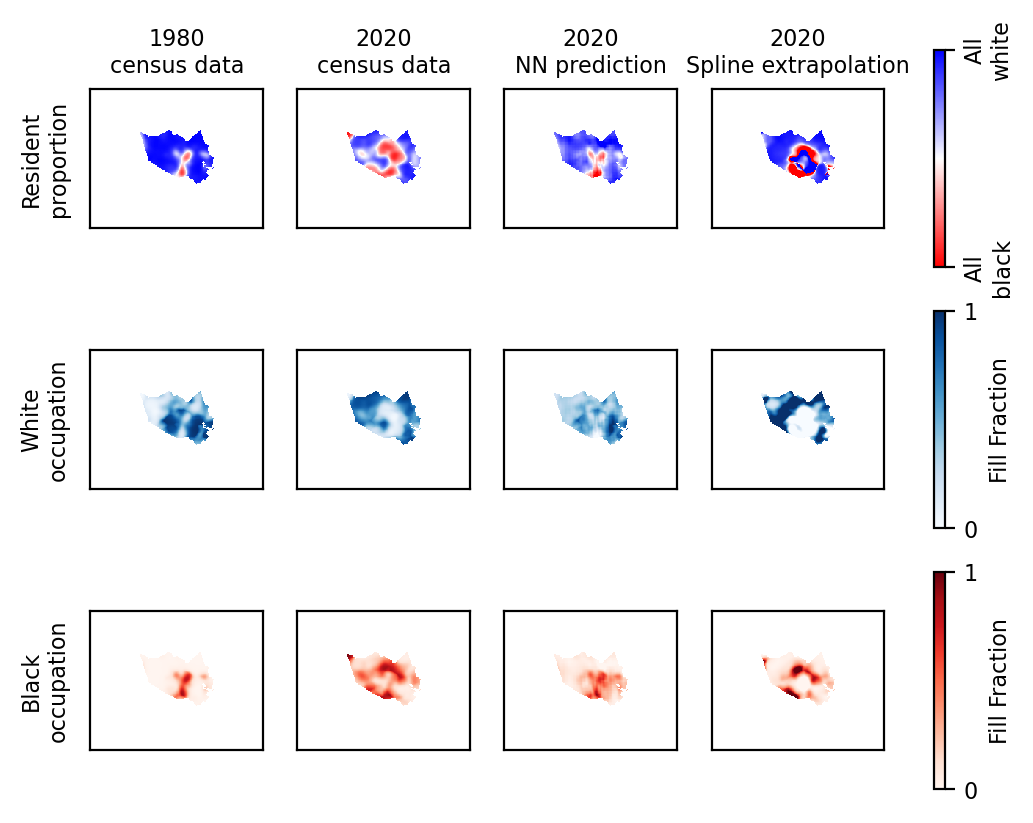

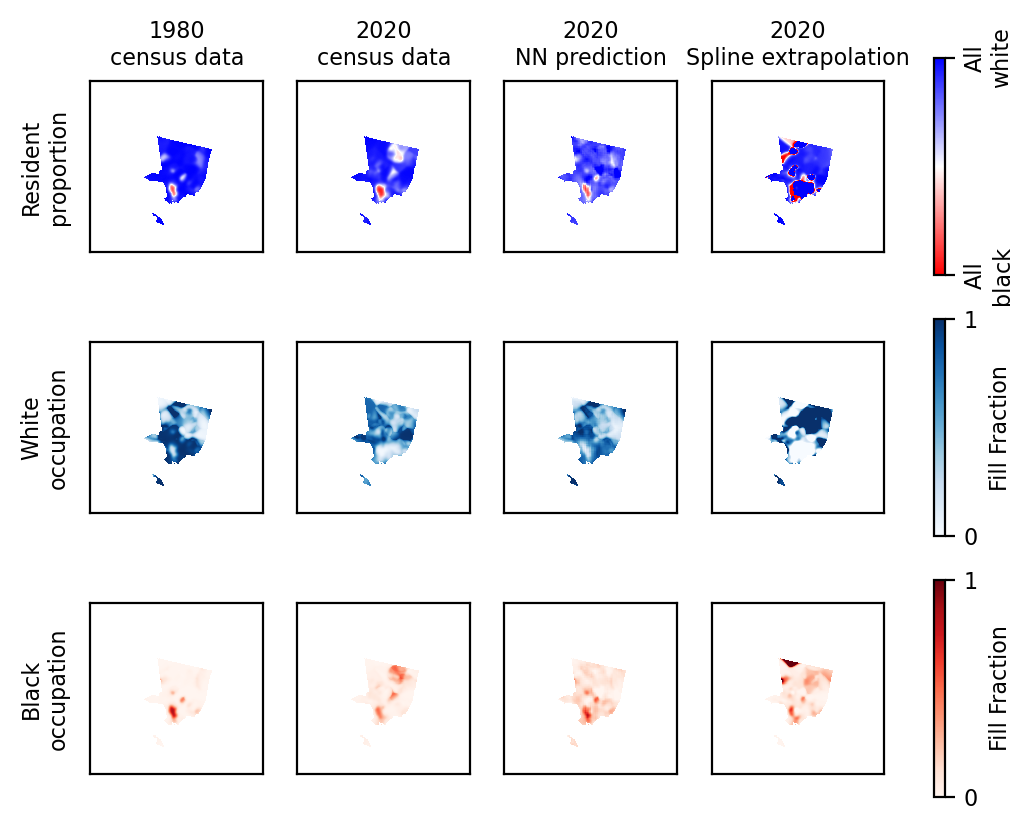

In [5]:
from census_nn import *
from pprint import pprint
import json

sub_df = df[df.objective == 'Fill fraction'].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/fixed_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Deal with rearranged paths
config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.3g}')

## Additional error calculation on models (including relative error)

In [3]:
import glob
import os
import yaml
import pandas as pd

from train_census_nn import get_model
from postprocessing import get_val_error

def get_val_errors(model, counties, dataset_kwargs):
    """ Return validation error (total MSE across validation counties) 
        and also compute relative validation error compared to no-dynamics
        baseline
    """
    ret = {
        'val_err': 0., # Total error over all counties
        'rel_val_err': 0., # Average relative error (counties are equal weight)
    }

    print(f'Computing validation errors over {counties}', flush=True)

    for county in counties:
        cerr = get_val_error(model, county, dataset_kwargs)
        ret['val_err'] += cerr['val_err']
        ret['rel_val_err'] += cerr['rel_val_err'] / len(counties)
    
    return ret

def overwrite_val_error(path):
    """ For legacy models that computed val loss instead of val_err
    """
    with open(f'{path}/config.yaml', 'r') as f:
        config = yaml.safe_load(f)

    info = torch.load(f'{path}/model_weight.ckpt', map_location='cpu')
    #if 'val_err' in info and 'rel_val_err' in info:
    #    print(f'Already have val_err in {path}')
    #    return

    # Fix rearranged paths
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

    model = get_model(config['model'])
    model.to(device)
    model.eval();

    ret = get_val_errors(model, config['dataset']['val_counties'], config['dataset']['kwargs'])
    val_err = ret['val_err']
    rel_val_err = ret['rel_val_err']
    print(f'Found val err of {val_err:.5g} and relative err of {rel_val_err:.5g}', flush=True)
    info['val_err'] = val_err
    info['rel_val_err'] = rel_val_err
    torch.save(info, f'{path}/model_weight.ckpt')

    return val_err


# Recompute validation errors and get relative errors
for path in glob.glob('models/fixed_sigma/*'):
    if not os.path.isdir(path): continue
    overwrite_val_error(path)

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701375_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0115


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.011504 and relative err of 0.7277


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0102


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010152 and relative err of 0.89524


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0106


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010555 and relative err of 0.71592


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00953


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0095253 and relative err of 0.65747


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0119


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.011922 and relative err of 0.65943


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_5/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00832


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0083187 and relative err of 0.55595


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0142


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.01416 and relative err of 0.8115


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701261_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0102


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010159 and relative err of 0.82475


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701261_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0126


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.012582 and relative err of 0.70575


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.013


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.012996 and relative err of 0.81956


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0161


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.016147 and relative err of 0.7731


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701375_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0127


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.012697 and relative err of 0.83196


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701261_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00922


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0092167 and relative err of 0.61845


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701258_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0107


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010684 and relative err of 0.92769


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00971


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0097074 and relative err of 0.71474


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0136


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.01355 and relative err of 0.81255


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_4/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0103


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010341 and relative err of 0.70474


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701258_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0168


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.016832 and relative err of 0.78454


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_4/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0103


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.01033 and relative err of 0.64355


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_4/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.011


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010961 and relative err of 0.84541


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_5/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0082


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.008196 and relative err of 0.56987


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761096_5/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0138


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.013818 and relative err of 0.84821


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701258_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0109


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010874 and relative err of 0.72463


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0103


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010288 and relative err of 0.6281


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701409_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0101


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010121 and relative err of 0.72585


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3761106_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00966


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0096584 and relative err of 0.67314


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/fixed_sigma/3701375_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0117


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.011662 and relative err of 0.96086
